## Data preprocessing

In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
from emnist import extract_training_samples, extract_test_samples
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

2023-08-23 14:16:30.862362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 14:16:32.262760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The digits and letters subsets of EMNIST dataset are separated, so we are going to extract and process them separately and later concatenate them into a single dataset

In [36]:
# extraction of the digits subset into train/test sets for features (X) and labels (y)
X_train_digits, y_train_digits = extract_training_samples('digits')
X_test_digits, y_test_digits = extract_test_samples('digits')

print('Digits subsets shapes:')
print(f'Train pics: {X_train_digits.shape}, train labels: {y_train_digits.shape}')
print(f'Test pics: {X_test_digits.shape}, test labels: {y_test_digits.shape}')

Digits subsets shapes:
Train pics: (240000, 28, 28), train labels: (240000,)
Test pics: (40000, 28, 28), test labels: (40000,)


In [37]:
# extraction of the letters subset into train/test sets for features (X) and labels (y)
X_train_letters, y_train_letters = extract_training_samples('letters')
X_test_letters, y_test_letters = extract_test_samples('letters')

print('Letters subsets shapes:')
print(f'Train pics: {X_train_letters.shape}, train labels {y_train_letters.shape}')
print(f'Test pics: {X_test_letters.shape}, test labels: {y_test_letters.shape}')

Letters subsets shapes:
Train pics: (124800, 28, 28), train labels (124800,)
Test pics: (20800, 28, 28), test labels: (20800,)


### Digits processing

The digits dataset is almost twice larger than the letters dataset. Moreover, there are 10 labels in the digits dataset (0-9), and 26 labels in the letters dataset (a-z), which means that there are about 24000 images of each digit and 4800 images of each letter. To avoid overfitting we will reduce the number of each digit in the train set to 4800 and in test set to 800

In [38]:
X_train = []
y_train = []
X_test = []
y_test = []

train_size = 4800
test_size = 800

for digit in range(10):

    # subsetting train sets
    train_indices = np.where(y_train_digits == digit)[0]

    selected_indices = np.random.choice(train_indices, size=train_size, replace=False)

    X_train.append(X_train_digits[selected_indices])
    y_train.append(y_train_digits[selected_indices])

    # subsetting test sets
    test_indices = np.where(y_test_digits == digit)[0]

    selected_indices = np.random.choice(test_indices, size=test_size, replace=False)

    X_test.append(X_test_digits[selected_indices])
    y_test.append(y_test_digits[selected_indices])

X_train_digits = np.concatenate(X_train)
y_train_digits = np.concatenate(y_train)
X_test_digits = np.concatenate(X_test)
y_test_digits = np.concatenate(y_test)

print('Reduced digits subset shapes:')
print(f'Train pics: {X_train_digits.shape}, train labels: {y_train_digits.shape}')
print(f'Test pics: {X_test_digits.shape}, test labels: {y_test_digits.shape}')

Reduced digits subset shapes:
Train pics: (48000, 28, 28), train labels: (48000,)
Test pics: (8000, 28, 28), test labels: (8000,)


### Letters processing

areThe letters 'I', 'O', and 'Q' have to be removed from the dataset, because VIN code doesn't contain them

In [39]:
print(np.unique(y_train_letters))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


Class labels 9, 15, and 17 with their corresponding feature vectors are to be deleted as they represent the above-mentioned letters

In [40]:
letters_to_remove = [9, 15, 17]

# Filter letter subsets excluding the specified letters
filtered_indices_train = np.logical_not(np.isin(y_train_letters, letters_to_remove))
filtered_indices_test = np.logical_not(np.isin(y_test_letters, letters_to_remove))

X_train_letters, y_train_letters = X_train_letters[filtered_indices_train], y_train_letters[filtered_indices_train]
X_test_letters, y_test_letters = X_test_letters[filtered_indices_test], y_test_letters[filtered_indices_test]

# Print the shapes of the filtered subsets
print('Shapes of subsets of filtered letters:')
print(f'Train pics: {X_train_letters.shape}, train labels: {y_train_letters.shape}')
print(f'Test pics: {X_test_letters.shape}, test labels: {y_test_letters.shape}')

Shapes of subsets of filtered letters:
Train pics: (110400, 28, 28), train labels: (110400,)
Test pics: (18400, 28, 28), test labels: (18400,)


In [41]:
# Increase the class labels of letters by 9, so that they won't clash with the digits labels
y_train_letters += 9
y_test_letters += 9

print(np.unique(y_test_letters))

[10 11 12 13 14 15 16 17 19 20 21 22 23 25 27 28 29 30 31 32 33 34 35]


In [11]:
# Update class labels
updated_label_mapping = {19:18, 20:19, 21:20, 22:21, 23:22,
                         25:23, 27:24, 28:25, 29:26, 30:27,
                         31:28, 32: 29, 33:30, 34:31, 35:32}

In [12]:
# Function to change class labels
def map_values(value):
  return updated_label_mapping.get(value,value)

mapped_values = np.vectorize(map_values)

y_train_letters = mapped_values(y_train_letters)
y_test_letters = mapped_values(y_test_letters)

In [13]:
print(np.unique(y_train_letters))

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]


The subsets of digits and letters are preprocessed. Now we can concatenate them into a single dataset

In [14]:
X_train = np.concatenate((X_train_letters, X_train_digits))
X_test = np.concatenate((X_test_letters, X_test_digits))
y_train = np.concatenate((y_train_letters, y_train_digits))
y_test = np.concatenate((y_test_letters, y_test_digits))

In [15]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (158400, 28, 28) (158400,)
Test: (26400, 28, 28) (26400,)


In [16]:
# Normalization of feature vectors
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [17]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(158400, 28, 28, 1) (26400, 28, 28, 1)
(158400, 33) (26400, 33)


In [18]:
train_label_counts = [0 for i in range(33)]
test_label_counts = [0 for i in range(33)]

for i in range(X_train.shape[0]):
  train_label_counts[np.argmax(y_train[i])] += 1

for i in range(X_test.shape[0]):
  test_label_counts[np.argmax(y_test[i])] += 1

In [55]:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
     'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
     'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W',
     'X', 'Y', 'Z']

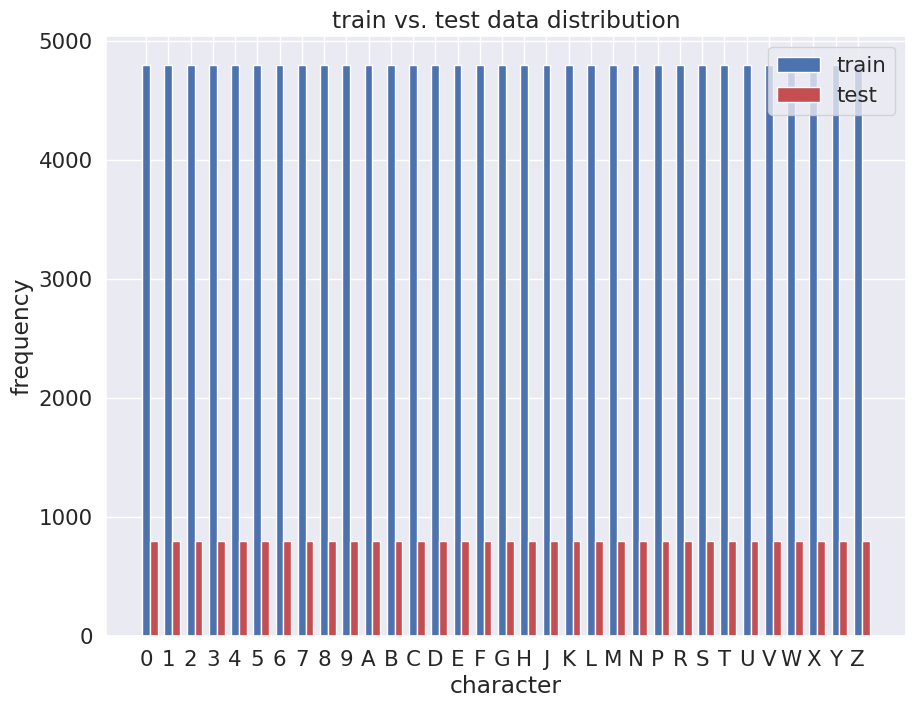

In [57]:
frequency = [
    train_label_counts, test_label_counts
]

fig =  plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

plt.xticks(range(len(frequency[0])), LABELS)
plt.title('train vs. test data distribution')
plt.xlabel('character')
plt.ylabel('frequency')

ax.bar(np.arange(len(frequency[0])), frequency[0], color='b', width=0.35)
ax.bar(np.arange(len(frequency[1])) + 0.35, frequency[1], color='r', width=0.35)
ax.legend(labels=['train', 'test'])

The dataset contains equal number of each character (33 characters, of which 23 letters and 10 digits), 4800 for training, and 800 testing. The dataset is ready for deep learning.

## Model architecture using CNN

In [20]:
model = keras.models.Sequential([
    keras.layers.Conv2D(128, (5,5), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, (5,5), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(33, activation='softmax')

])

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 256)         0

### The model below produces a slightly better validation accuracy, but it overfits, graphs for losses and accuracies are shown in the markdown for the project (Readme file)

In [ ]:
# model = keras.models.Sequential([
#     keras.layers.Conv2D(128, (5,5), activation='relu', input_shape=(28,28,1)),
#     keras.layers.MaxPooling2D(2,2),
#     keras.layers.Dropout(0.25),

#     keras.layers.Conv2D(256, (5,5), activation='relu'),
#     keras.layers.MaxPooling2D(2,2),
#     keras.layers.Dropout(0.25),

#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.15),

#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.Dropout(0.15)
#     keras.layers.Dense(33, activation='softmax')

# ])

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

In [21]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    )

Epoch 1/25
4950/4950 [==============================] - 47s 7ms/step - loss: 1.4877 - accuracy: 0.5844 - val_loss: 0.7489 - val_accuracy: 0.7717
Epoch 2/25
4950/4950 [==============================] - 36s 7ms/step - loss: 0.7096 - accuracy: 0.7793 - val_loss: 0.4886 - val_accuracy: 0.8441
Epoch 3/25
4950/4950 [==============================] - 36s 7ms/step - loss: 0.5307 - accuracy: 0.8301 - val_loss: 0.3879 - val_accuracy: 0.8756
Epoch 4/25
4950/4950 [==============================] - 35s 7ms/step - loss: 0.4455 - accuracy: 0.8553 - val_loss: 0.3375 - val_accuracy: 0.8921
Epoch 5/25
4950/4950 [==============================] - 36s 7ms/step - loss: 0.3933 - accuracy: 0.8714 - val_loss: 0.3051 - val_accuracy: 0.9003
Epoch 6/25
4950/4950 [==============================] - 35s 7ms/step - loss: 0.3584 - accuracy: 0.8819 - val_loss: 0.2862 - val_accuracy: 0.9047
Epoch 7/25
4950/4950 [==============================] - 35s 7ms/step - loss: 0.3326 - accuracy: 0.8898 - val_loss: 0.2690 - val_ac

## Model evaluation

Text(0.5, 1.0, 'Accuracy Curves')

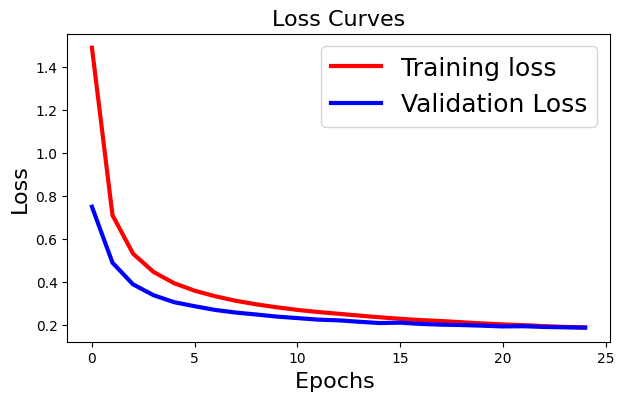

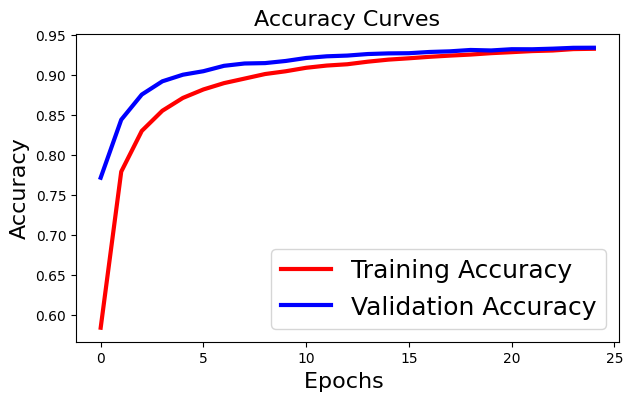

In [22]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[7,4])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[7,4])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [23]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
loss, acc = model.evaluate(X_test, y_test)
print(loss, acc)

825/825 [==============================] - 3s 4ms/step - loss: 0.1864 - accuracy: 0.9341
0.18644024431705475 0.9340530037879944


In [25]:
predictions = model.predict(X_test)

825/825 [==============================] - 2s 2ms/step


In [26]:
import numpy as np

confusion_matrix = confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(predictions, axis=1)
)

In [27]:
print(confusion_matrix)

[[778   0   0 ...   0   0   0]
 [  0 589   0 ...   0   0   0]
 [  0   0 739 ...   0   0  48]
 ...
 [  0   0   1 ... 768   9   2]
 [  0   0   0 ...   3 747   1]
 [  0   0  59 ...   0   0 735]]


<Axes: xlabel='predicted values', ylabel='actual values'>

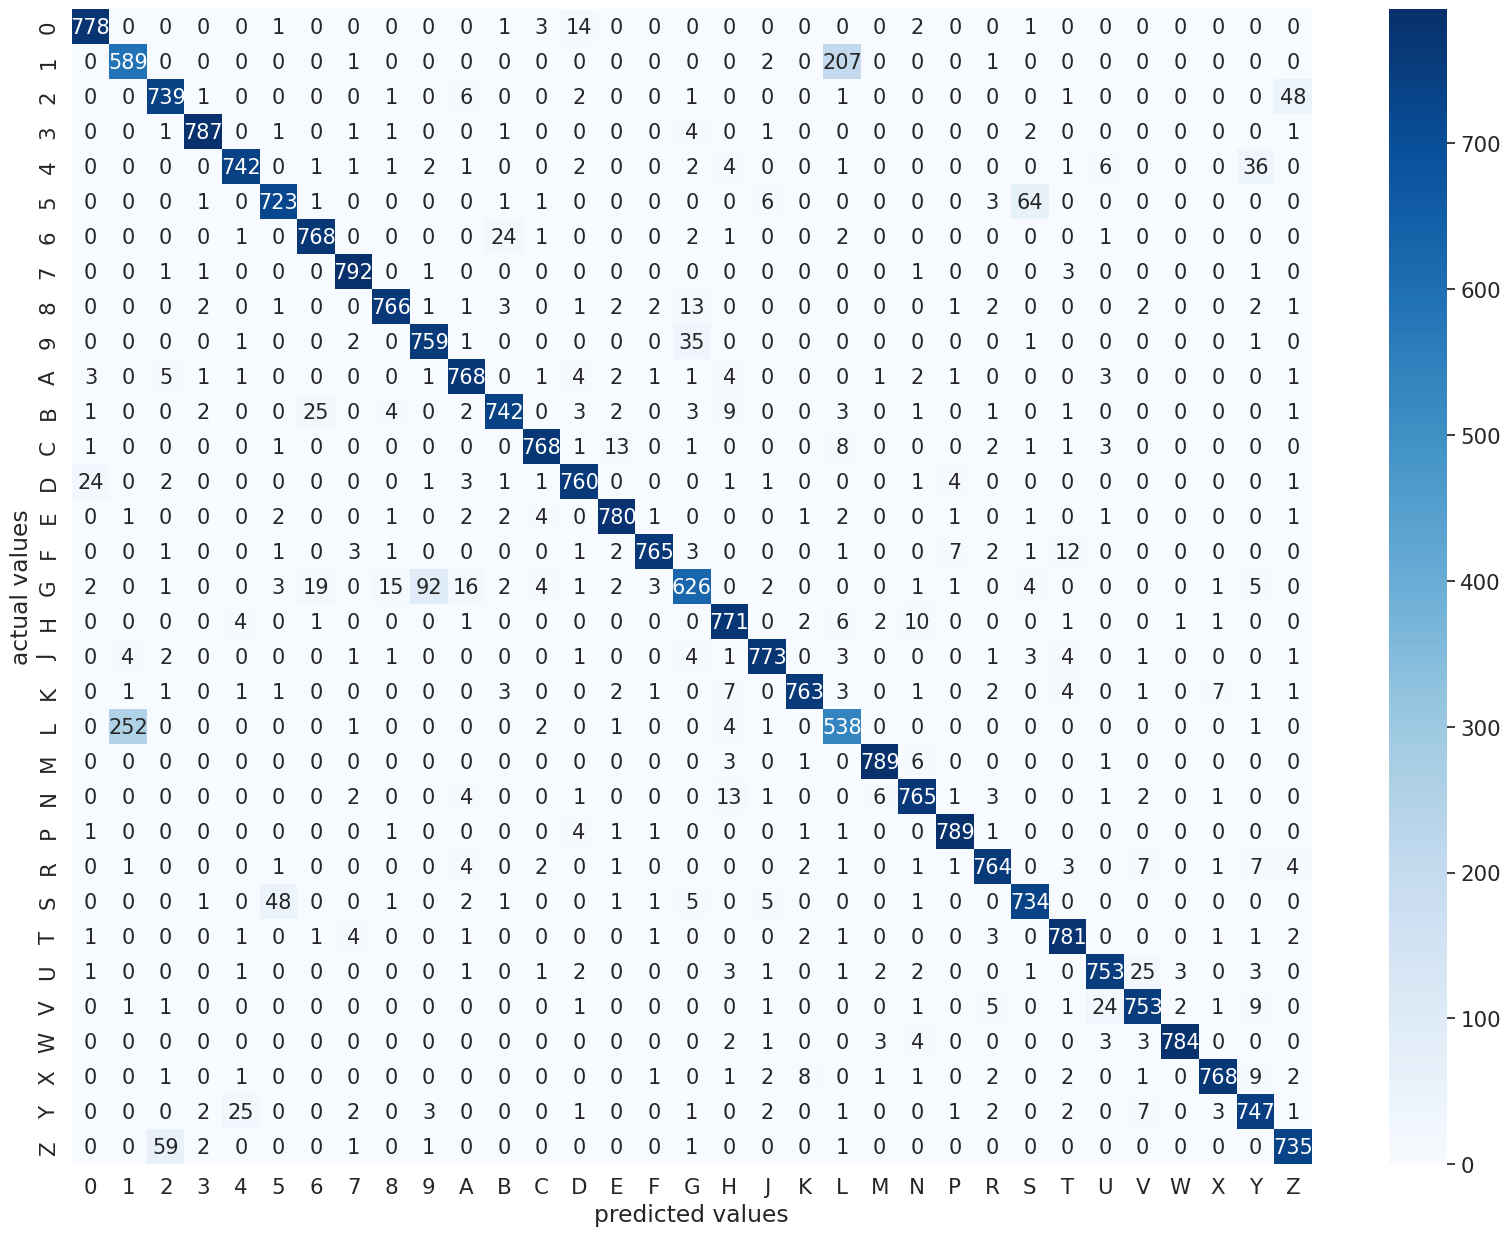

In [58]:
df_cm = pd.DataFrame(confusion_matrix, columns=np.unique(labels), index = np.unique(LABELS))
df_cm.index.name = 'actual values'
df_cm.columns.name = 'predicted values'
plt.figure(figsize = (20,15))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size': 15}, fmt='d')

In [30]:
# flatten arrays and fetch class labels
y_test_ = np.argmax(y_test, axis=1)
y_pred_ = np.argmax(predictions, axis=1)

print(classification_report(y_test_, y_pred_, target_names=labels))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       800
           1       0.69      0.74      0.71       800
           2       0.91      0.92      0.92       800
           3       0.98      0.98      0.98       800
           4       0.95      0.93      0.94       800
           5       0.92      0.90      0.91       800
           6       0.94      0.96      0.95       800
           7       0.98      0.99      0.98       800
           8       0.97      0.96      0.96       800
           9       0.88      0.95      0.91       800
           A       0.94      0.96      0.95       800
           B       0.95      0.93      0.94       800
           C       0.97      0.96      0.97       800
           D       0.95      0.95      0.95       800
           E       0.96      0.97      0.97       800
           F       0.98      0.96      0.97       800
           G       0.89      0.78      0.83       800
           H       0.94    

In [31]:
model.save('model.h5')